In [83]:
# Importing necessary libraries

import os
import pandas as pd
import numpy as np

#Importing Visualization libraries

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
%matplotlib inline

#Tensorflow libraries

import tensorflow as tf
import cv2
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from keras.models import Sequential, Model
from keras.layers import Conv2D ,MaxPooling2D, Flatten, Dense, Dropout
from keras import optimizers

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

#Model Evaluation libraries

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from mlxtend.plotting import plot_confusion_matrix


In [22]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [23]:
auth.authenticate_user()
gauth=GoogleAuth()
gauth.credentials=GoogleCredentials.get_application_default()
drive=GoogleDrive(gauth)

In [24]:
fid=drive.ListFile({'q':"title='archive.zip'"}).GetList()[0]['id']
f=drive.CreateFile({'id':fid})
f.GetContentFile('archive.zip')

In [25]:
f.keys()

dict_keys(['id', 'kind', 'etag', 'selfLink', 'webContentLink', 'alternateLink', 'embedLink', 'iconLink', 'title', 'mimeType', 'labels', 'copyRequiresWriterPermission', 'createdDate', 'modifiedDate', 'modifiedByMeDate', 'lastViewedByMeDate', 'markedViewedByMeDate', 'version', 'parents', 'downloadUrl', 'userPermission', 'originalFilename', 'fileExtension', 'md5Checksum', 'fileSize', 'quotaBytesUsed', 'ownerNames', 'owners', 'lastModifyingUserName', 'lastModifyingUser', 'capabilities', 'editable', 'copyable', 'writersCanShare', 'shared', 'explicitlyTrashed', 'appDataContents', 'headRevisionId', 'spaces'])

In [26]:
!unzip archive.zip

Archive:  archive.zip
replace TB_Chest_Radiography_Database/Normal.metadata.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace TB_Chest_Radiography_Database/Normal/Normal-1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1.png  
replace TB_Chest_Radiography_Database/Normal/Normal-10.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: TB_Chest_Radiography_Database/Normal/Normal-10.png  
replace TB_Chest_Radiography_Database/Normal/Normal-100.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [66]:
base_dir="/content/gdrive/MyDrive/Colab Notebooks/TB_Chest_Radiography_Database/"
os.chdir("/content/gdrive/MyDrive/Colab Notebooks/TB_Chest_Radiography_Database/")
!ls

Normal		      README.md.txt  Tuberculosis.metadata.xlsx
Normal.metadata.xlsx  Tuberculosis


In [67]:
tuberculosis_data="/content/gdrive/MyDrive/Colab Notebooks/TB_Chest_Radiography_Database/Tuberculosis"
print("Tuberculosis images:\n",os.listdir(tuberculosis_data)[:5])

Tuberculosis images:
 ['Tuberculosis-325.png', 'Tuberculosis-3251.png', 'Tuberculosis-3250.png', 'Tuberculosis-3252.png', 'Tuberculosis-3253.png']


In [68]:
normal_data ="/content/gdrive/MyDrive/Colab Notebooks/TB_Chest_Radiography_Database/Normal"
print("\nNormal images:\n",os.listdir(normal_data)[:5])


Normal images:
 ['Normal-3249.png', 'Normal-325.png', 'Normal-3250.png', 'Normal-3251.png', 'Normal-3252.png']


In [69]:
print("Number of Tuberculosis images :", len(os.listdir(tuberculosis_data)))
print("Number of Normal images :" , len(os.listdir(normal_data)))

Number of Tuberculosis images : 3500
Number of Normal images : 3500


Lets have a look at the images

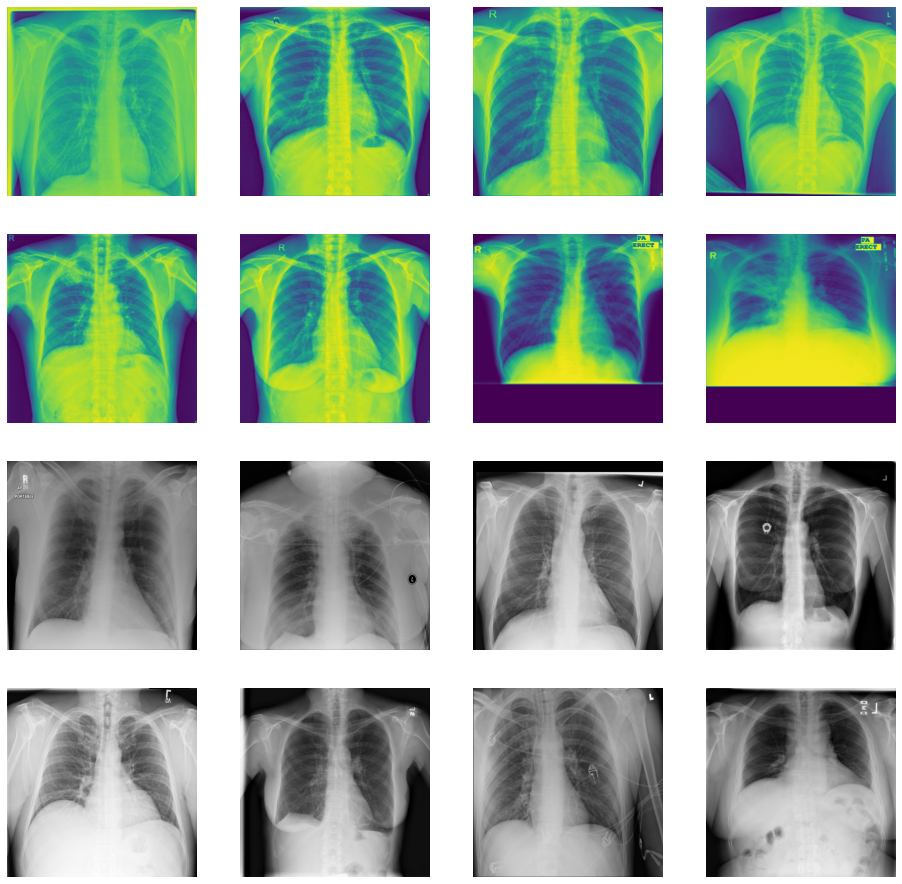

In [70]:
nrows=4
ncols=4
pic_index=0
fig= plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index+=8


tuberculosis_img = [os.path.join(tuberculosis_data, image) for image in os.listdir(tuberculosis_data)[pic_index-8:pic_index]]
normal_img = [os.path.join(normal_data, image) for image in os.listdir(normal_data)[pic_index-8:pic_index]]

for i, image_path in enumerate(tuberculosis_img+normal_img):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') 

    img = mpimg.imread(image_path)
    plt.imshow(img)

plt.show()

In [71]:
image= imread("/content/gdrive/MyDrive/Colab Notebooks/TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-2422.png")
image.shape

(512, 512)

Generating Train & Validation set using Data Augmentation

In [72]:
# generating training data
print("training data :")
train_datagen= ImageDataGenerator(rescale=1/255, zoom_range=0.3, rotation_range=50, width_shift_range= 0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest', validation_split = 0.2)

train_data = train_datagen.flow_from_directory(base_dir, 
                                              target_size= (300, 300),
                                              class_mode= "binary",
                                              batch_size=20,
                                              subset= "training"
                                              )

# genarating validation data
print("\nvalidation data :")
val_datagen= ImageDataGenerator(rescale= 1/255, validation_split= 0.2)

val_data= train_datagen.flow_from_directory(base_dir, 
                                              target_size= (300, 300),
                                              class_mode= "binary",
                                              batch_size=20,
                                              shuffle= False,
                                              subset= "validation"
                                              )

training data :
Found 5600 images belonging to 2 classes.

validation data :
Found 1400 images belonging to 2 classes.


Class Labels

In [73]:
train_data.class_indices

{'Normal': 0, 'Tuberculosis': 1}

Model Building

**Transfer Learning-InceptionV3 Model**
Inception v3 is a convolutional neural network for assisting in image analysis and object detection, and got its start as a module for Googlenet. It is the third edition of Google's Inception Convolutional Neural Network, originally introduced during the ImageNet Recognition Challenge. Just as ImageNet can be thought of as a database of classified visual objects, Inception helps classification of objects in the world of computer vision. One such use is in life sciences, where it aids in the research of Leukemia. The original name (Inception) was codenamed this way after a popular "'we need to go deeper' internet meme" went viral, quoting a phrase from Inception film of Christopher Nolan.

In [74]:
# inceptionV3 model, with include_top= False we are not using fully connected layer of the inceptionV3 model, instead we
#  will create our own Fully Connected and Output Layer according to our training data
inception_model= InceptionV3(input_shape= (300, 300,3), include_top= False, weights="imagenet")

# Since we are creating our own fully connected layer we need output of the last inception model layer and flatten them 
last_output= inception_model.layers[-1].output

# Flattening the last output
last_output= Flatten()(last_output)

# Our pretrained model
pretrained_model= Model(inception_model.input, last_output) 

87916544/87910968 [==============================] - 1s 0us/step


In [75]:
pretrained_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

Creating Dense Layer

In [76]:
# layer 1
x= Dense(units=512, activation="relu")(last_output)
x=Dropout(0.2)(x)

# layer 2
x= Dense(units=128, activation="relu")(x)
x=Dropout(0.2)(x)

# output layer
x= Dense(units=1, activation="sigmoid")(x)

# final model
model= Model(pretrained_model.input, x)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [79]:
# compile model
model.compile(loss="binary_crossentropy", optimizer=optimizers.RMSprop(lr=1e-4), metrics=["accuracy"])

# Since the layers of InceptionV3 model are already trained, we don't want them to be trained again. 
# So we will freeze these layers
for layer in pretrained_model.layers:
    layer.trainable= False

# model fitting
history= model.fit(train_data,
                   steps_per_epoch= train_data.samples//train_data.batch_size,
                   validation_data= val_data,
                   validation_steps= val_data.samples//val_data.batch_size,
                   epochs= 10,
                   verbose=1
                  )

Epoch 1/10
280/280 [==============================] - 2648s 9s/step - loss: 0.6522 - accuracy: 0.7568 - val_loss: 0.2789 - val_accuracy: 0.9029
Epoch 2/10
280/280 [==============================] - 1325s 5s/step - loss: 0.3322 - accuracy: 0.8729 - val_loss: 0.2098 - val_accuracy: 0.9164
Epoch 3/10
280/280 [==============================] - 1324s 5s/step - loss: 0.2587 - accuracy: 0.9078 - val_loss: 0.1698 - val_accuracy: 0.9364
Epoch 4/10
280/280 [==============================] - 1319s 5s/step - loss: 0.2493 - accuracy: 0.9106 - val_loss: 0.1867 - val_accuracy: 0.9321
Epoch 5/10
280/280 [==============================] - 1318s 5s/step - loss: 0.2228 - accuracy: 0.9226 - val_loss: 0.1532 - val_accuracy: 0.9379
Epoch 6/10
280/280 [==============================] - 1325s 5s/step - loss: 0.1877 - accuracy: 0.9312 - val_loss: 0.1195 - val_accuracy: 0.9529
Epoch 7/10
280/280 [==============================] - 1316s 5s/step - loss: 0.1859 - accuracy: 0.9336 - val_loss: 0.1360 - val_accuracy:

Model Evaluation

In [80]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

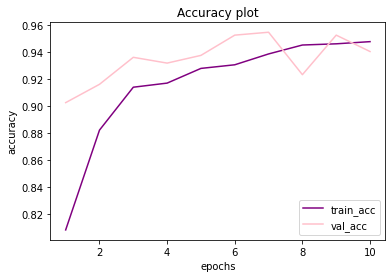

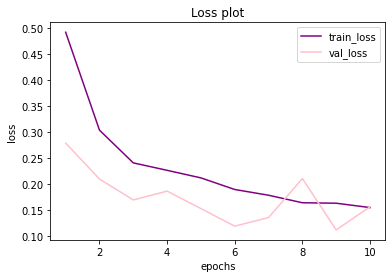

In [81]:
epochs= range(1, len(history.history["accuracy"])+1)

plt.plot(epochs, history.history["accuracy"], color="purple")
plt.plot(epochs, history.history["val_accuracy"], color="pink")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy plot")
plt.legend(["train_acc", "val_acc"])
plt.show()

plt.plot(epochs, history.history["loss"], color="purple")
plt.plot(epochs, history.history["val_loss"], color="pink")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss plot")
plt.legend(["train_loss", "val_loss"])
plt.show()

Checking Model Performance

In [85]:
prediction= model.predict(val_data, steps=np.ceil(val_data.samples/val_data.batch_size), verbose=1)
prediction= (prediction > 0.5)
prediction

70/70 [==============================] - 239s 3s/step


array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [86]:
val_labels=val_data.classes
val_labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [87]:
prediction.shape

(1400, 1)

In [88]:
val_labels.shape

(1400,)

0.935
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       700
           1       0.89      0.99      0.94       700

    accuracy                           0.94      1400
   macro avg       0.94      0.94      0.93      1400
weighted avg       0.94      0.94      0.93      1400



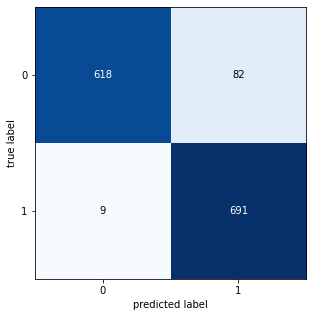

In [89]:
cm= confusion_matrix(val_data.classes, prediction)
plot_confusion_matrix(cm, figsize=(5,5))

print(accuracy_score(val_data.classes, prediction))
print(classification_report(val_data.classes, prediction))

In [90]:
model.save("tuberculosis.h5")